In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

import tensorflow as tf
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Mounted at /content/drive


#1. Data Load

In [3]:
trainX_df = read_csv('/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset/train/X_train.txt',header=None, delim_whitespace=True)
trainy_df = read_csv('/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset/train/y_train.txt',header=None, delim_whitespace=True)

testX_df = read_csv('/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset/test/X_test.txt',header=None, delim_whitespace=True)
testy_df = read_csv('/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset/test/y_test.txt',header=None, delim_whitespace=True)


In [4]:
trainX=np.array(trainX_df)
trainy=np.array(trainy_df)-1
testX=np.array(testX_df)
testy=np.array(testy_df)-1

In [5]:
np.unique(trainy)

array([0, 1, 2, 3, 4, 5])

In [6]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)


(7352, 561)
(7352, 1)
(2947, 561)


In [7]:
from sklearn.preprocessing import StandardScaler
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

In [8]:
from sklearn.model_selection import train_test_split
# Create train and test sets
trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.25, random_state=1,stratify= trainy)


In [9]:
from numpy import array
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [10]:

# Merge train and test X/y data to apply sequence transformation function
train_set = np.c_[trainX, trainy]
test_set = np.c_[testX, testy]
val_set = np.c_[valX, valy]


# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 25)
print(X_val.shape, y_val.shape)

(5490, 25, 561) (5490,)
(2923, 25, 561) (2923,)
(1814, 25, 561) (1814,)


In [11]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train.astype(int))
print(y_train.shape)

y_test = to_categorical(y_test.astype(int))
print(y_test.shape)

y_val = to_categorical(y_val.astype(int))
print(y_val.shape)

(5490, 6)
(2923, 6)
(1814, 6)


## 2. CNN for feature 추출한 데이터 Input (split_sequences 반드시 사용)

In [12]:

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[-1]

# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            107776    
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 128)               188544    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 297094 (1.13 MB)
Trainable params: 297094 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
train_epochs = 50
history = model.fit(X_train, y_train, epochs=train_epochs, verbose=True,  validation_data = (X_val, y_val))


Epoch 1/50
172/172 [==============================] - 3s 9ms/step - loss: 1.1250 - accuracy: 0.5020 - val_loss: 0.5488 - val_accuracy: 0.7536
Epoch 2/50
172/172 [==============================] - 1s 5ms/step - loss: 0.3351 - accuracy: 0.8628 - val_loss: 0.3365 - val_accuracy: 0.8545
Epoch 3/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1702 - accuracy: 0.9337 - val_loss: 0.2555 - val_accuracy: 0.8969
Epoch 4/50
172/172 [==============================] - 1s 6ms/step - loss: 0.0999 - accuracy: 0.9643 - val_loss: 0.2937 - val_accuracy: 0.8914
Epoch 5/50
172/172 [==============================] - 1s 6ms/step - loss: 0.0717 - accuracy: 0.9741 - val_loss: 0.2541 - val_accuracy: 0.9074
Epoch 6/50
172/172 [==============================] - 1s 6ms/step - loss: 0.0423 - accuracy: 0.9849 - val_loss: 0.2225 - val_accuracy: 0.9239
Epoch 7/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0233 - accuracy: 0.9916 - val_loss: 0.2175 - val_accuracy: 0.9283
Epoch 

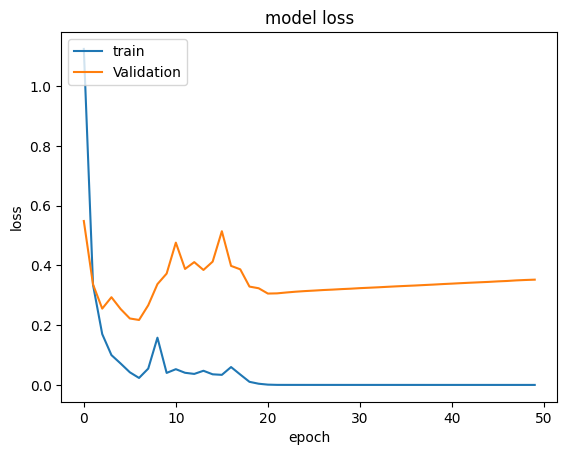

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


# 3. Evaluation

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test ,verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)


Accuracy of the CNN model 0.9336298108100891
92/92 [==============================] - 0s 2ms/step


**** Confusion Matrix ****
[[479   3  14   0   0   0]
 [ 18 438  15   0   0   0]
 [ 12  23 385   0   0   0]
 [  0   1   0 452  38   0]
 [  0   0   0  62 446   0]
 [  1   1   0   1   5 529]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.94      0.97      0.95       496
           2       0.94      0.93      0.93       471
           3       0.93      0.92      0.92       420
           4       0.88      0.92      0.90       491
           5       0.91      0.88      0.89       508
           6       1.00      0.99      0.99       537

    accuracy                           0.93      2923
   macro avg       0.93      0.93      0.93      2923
weighted avg       0.93      0.93      0.93      2923



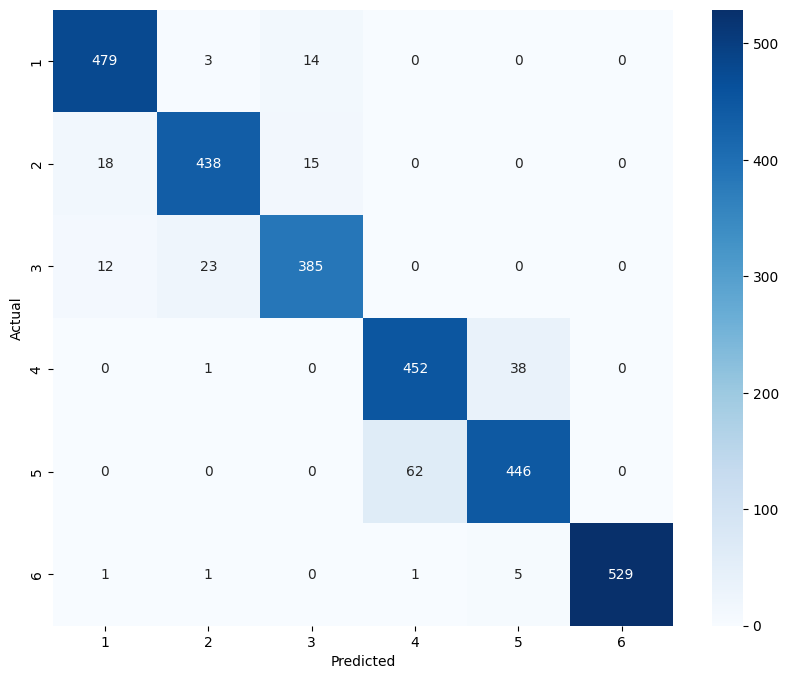

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["1","2","3","4","5","6"]
display_results(y_test,predictions,classNames)
